In [1]:
import pandas as pd
import numpy as np
import random
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_columns', None)
# Right after importing seaborn (could also use 'whitegrid')
sns.set_theme(style='darkgrid', context='talk')

import warnings
warnings.filterwarnings('ignore')

from fbprophet import Prophet
from fbprophet.diagnostics import performance_metrics
from fbprophet.diagnostics import cross_validation
from sklearn.metrics import mean_squared_error
from numpy import sqrt

In [2]:
#pip install fbprophet

In [2]:
data=pd.read_csv('data_cleaned.csv', parse_dates=['date'], index_col=0)
data.head()

,order_id,date,item_code,quantity,unit_price_vat_excl,unit_cogs,net_revenue,gross_revenue,margin_revenue,country,item_name,style,name,group0,group1,category
0,1.900052e+09,2019-06-04,ZB00025746,1,9.412096,0.000000,9.412096,0.000000,9.412096,Romania,YTH LEAGUE KNIT SHORT NB,725990-010,Nike,Apparel,Pants,football
1,1.900101e+09,2019-07-15,ZB00025746,1,8.648837,5.393411,8.648837,5.393411,3.255426,Czech Republic,YTH LEAGUE KNIT SHORT NB,725990-010,Nike,Apparel,Pants,football
2,1.900107e+09,2019-07-24,ZB00025746,1,8.648837,5.458527,8.648837,5.458527,3.190310,Czech Republic,YTH LEAGUE KNIT SHORT NB,725990-010,Nike,Apparel,Pants,football
3,1.900111e+09,2019-08-01,ZB00025746,1,8.648837,5.440310,8.648837,5.440310,3.208527,Czech Republic,YTH LEAGUE KNIT SHORT NB,725990-010,Nike,Apparel,Pants,football
4,1.900052e+09,2019-06-04,ZB00022010,1,12.784729,4.087597,12.784729,4.087597,8.697132,Romania,NK MERC LT GRD,sp2120-703,Nike,Equipment,Guards,football


In [4]:
def select_series(data, time_period='day', revenue='net'):
    time_periods = {
        'day': 'D',
        'week': 'W',
        'month': 'M'}
    
    revenue_cat = {
        'net':'net_revenue',
        'gross':'gross_revenue',
        'margin':'margin_revenue'}
    
    data = data.set_index('date')
    data = data[revenue_cat[revenue]].resample(time_periods[time_period]).sum()
    data = pd.DataFrame(data).reset_index()
    return data

In [5]:
daily_sales=select_series(data)
daily_sales.columns=['ds', 'y']
daily_sales.ds=pd.to_datetime(daily_sales['ds'])
daily_sales.sort_values('ds')
daily_sales.head()

,ds,y
0,2019-06-01,27686.366016
1,2019-06-02,3511.559646
2,2019-06-03,7006.124367
3,2019-06-04,80530.520659
4,2019-06-05,86484.287754


In [6]:
#daily_sales['y']=np.log(daily_sales['y'])

In [7]:

train_df=daily_sales[:int(daily_sales.shape[0]*0.75)]

test_df=daily_sales[int(daily_sales.shape[0]*0.75):]
print(train_df.shape)
print(test_df.shape)

(530, 2)
(177, 2)


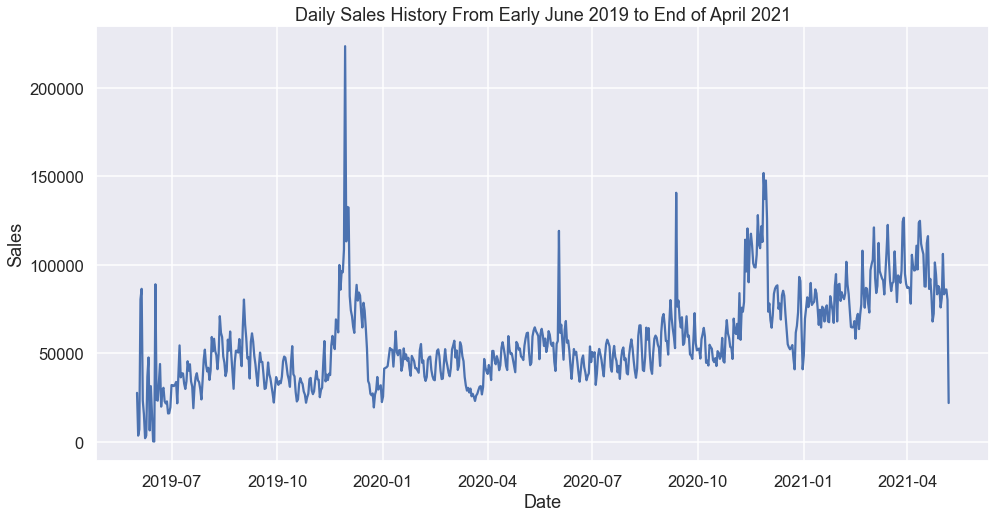

In [8]:
fig, ax = plt.subplots(figsize=(16, 8))
sns.lineplot(x='ds', y='y', data=daily_sales, ax=ax)
ax.set(title='Daily Sales History From Early June 2019 to End of April 2021', ylabel='Sales', xlabel='Date');

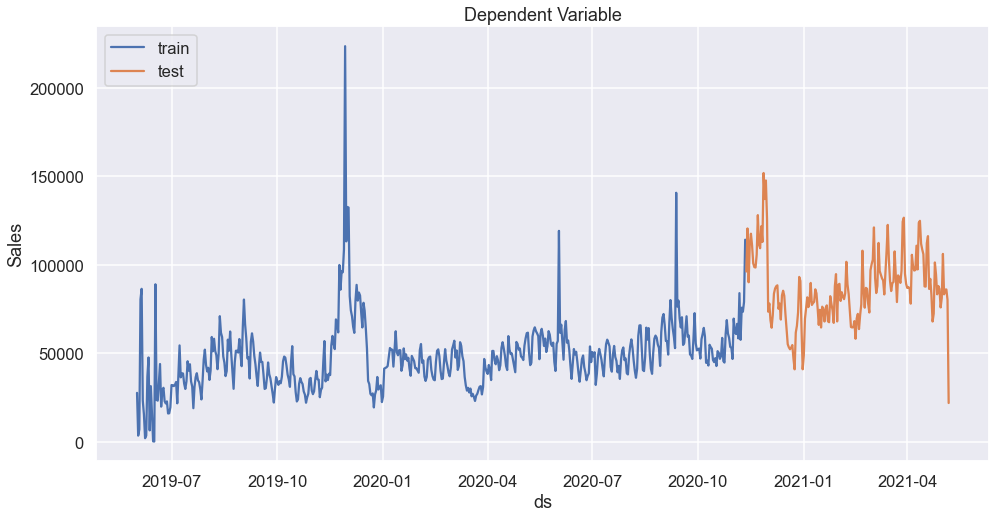

In [9]:
fig, ax = plt.subplots(figsize=(16, 8))
sns.lineplot(x='ds', y='y', label='train', data=train_df, ax=ax)
sns.lineplot(x='ds', y='y', label='test', data=test_df, ax=ax)

ax.legend(loc='upper left')
ax.set(title='Dependent Variable', ylabel='Sales');

In [10]:
#training the model on training set
model=Prophet(weekly_seasonality=True, daily_seasonality=False, n_changepoints=3)
model.add_seasonality(name='monthly', period=30, fourier_order=1)
model.fit(train_df)

INFO:numexpr.utils:NumExpr defaulting to 4 threads.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [11]:
future=model.make_future_dataframe(periods=207, freq='D')
forecast=model.predict(future)

In [12]:
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,monthly,monthly_lower,monthly_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2019-06-01,32865.436568,1849.732011,44656.023094,32865.436568,32865.436568,-9993.301272,-9993.301272,-9993.301272,-1404.875811,-1404.875811,-1404.875811,-8588.425461,-8588.425461,-8588.425461,0.0,0.0,0.0,22872.135296
1,2019-06-02,32961.302931,11468.121026,53645.715394,32961.302931,32961.302931,-64.980015,-64.980015,-64.980015,-841.612082,-841.612082,-841.612082,776.632067,776.632067,776.632067,0.0,0.0,0.0,32896.322916
2,2019-06-03,33057.169294,19003.797286,61748.729532,33057.169294,33057.169294,6933.507927,6933.507927,6933.507927,-241.565867,-241.565867,-241.565867,7175.073794,7175.073794,7175.073794,0.0,0.0,0.0,39990.677221
3,2019-06-04,33153.035657,18167.127275,58584.236592,33153.035657,33153.035657,4768.330971,4768.330971,4768.330971,369.037935,369.037935,369.037935,4399.293035,4399.293035,4399.293035,0.0,0.0,0.0,37921.366627
4,2019-06-05,33248.902019,14660.485216,58816.101031,33248.902019,33248.902019,3068.319762,3068.319762,3068.319762,963.513009,963.513009,963.513009,2104.806753,2104.806753,2104.806753,0.0,0.0,0.0,36317.221782


In [13]:
# We want to look at yhat, yhat_lower, and yhat_upper only. 
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()

,ds,yhat,yhat_lower,yhat_upper
0,2019-06-01,22872.135296,1849.732011,44656.023094
1,2019-06-02,32896.322916,11468.121026,53645.715394
2,2019-06-03,39990.677221,19003.797286,61748.729532
3,2019-06-04,37921.366627,18167.127275,58584.236592
4,2019-06-05,36317.221782,14660.485216,58816.101031


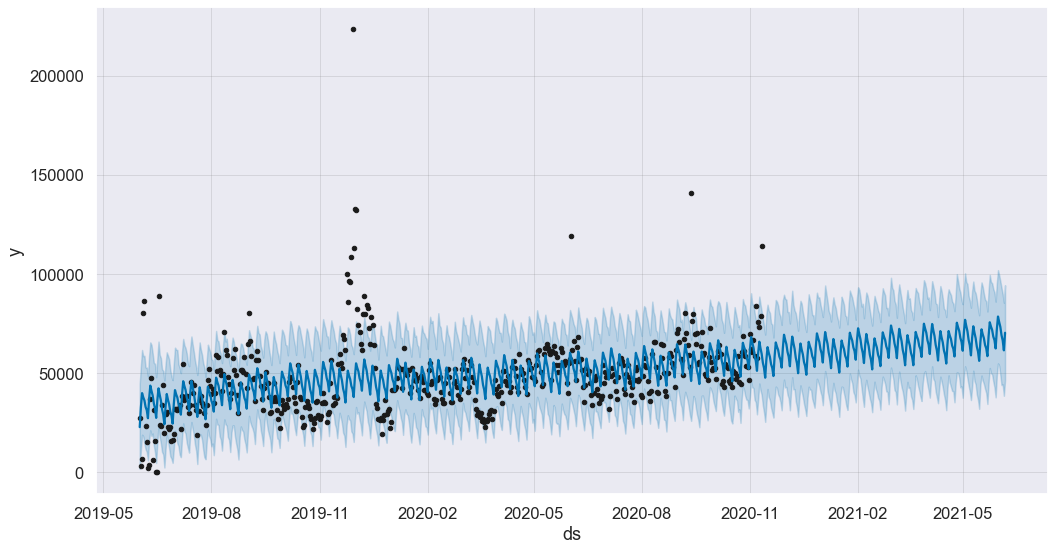

In [14]:
#ploting the forecast
f, ax=plt.subplots(1)
f.set_figheight(8)
f.set_figwidth(15)

fig=model.plot(forecast, ax=ax)
plt.show()

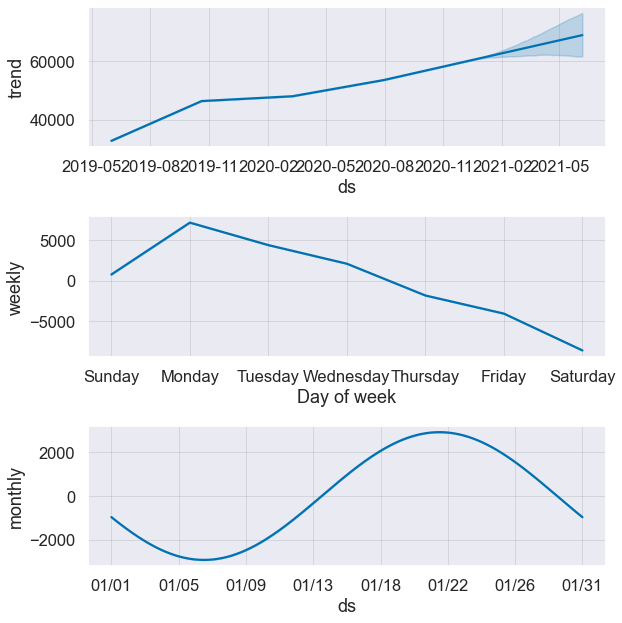

In [15]:
# ploting model components
model.plot_components(forecast)
plt.show()

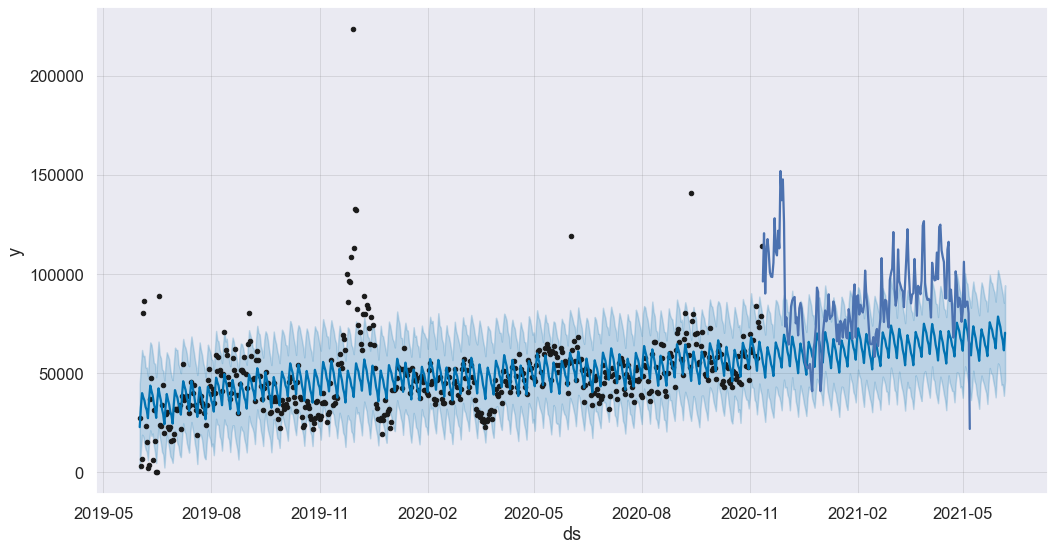

In [16]:
 # comparing Forecast to Actual

f, ax=plt.subplots(1)
f.set_figheight(8)
f.set_figwidth(15)


fig=model.plot(forecast, ax=ax)
ax.plot(test_df.ds, test_df.y)



Text(0.5, 1.0, 'One Month Forecast Vs Actual, March 1 to 30, 2021')

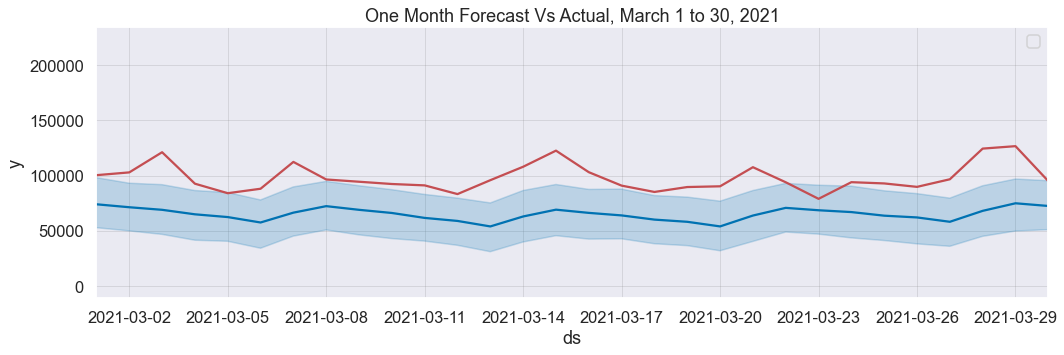

In [17]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.plot(test_df['ds'], test_df['y'], color='r')
fig = model.plot(forecast, ax=ax)
ax.set_xbound(lower='2021-03-01', upper='2021-03-30')
plt.legend()
plt.title('One Month Forecast Vs Actual, March 1 to 30, 2021')



Text(0.5, 1.0, 'One month Forecast Vs Actual, April 07 to May 6 , 2021')

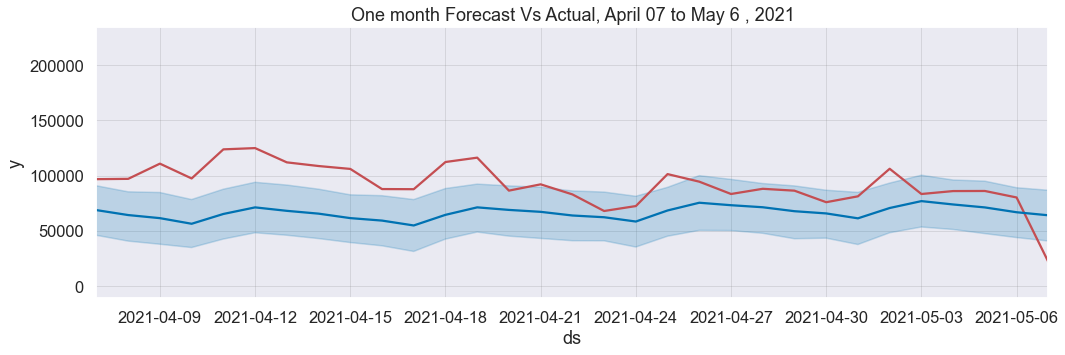

In [18]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.plot(test_df['ds'], test_df['y'], color='r')
fig = model.plot(forecast, ax=ax)
ax.set_xbound(lower='2021-04-07', upper='2021-05-07')

plt.title('One month Forecast Vs Actual, April 07 to May 6 , 2021')

Text(0.5, 1.0, 'One month Forecast, May 07 to June 6, 2021')

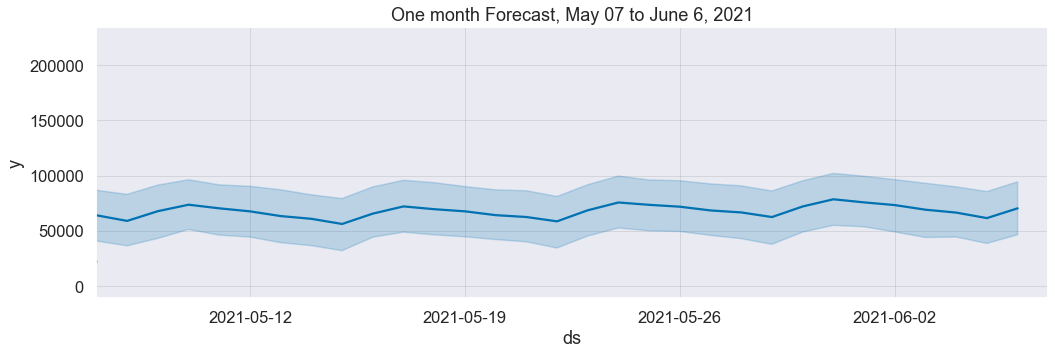

In [19]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.plot(test_df['ds'], test_df['y'], color='r')
fig = model.plot(forecast, ax=ax)
ax.set_xbound(lower='2021-05-07', upper='2021-06-07')

plt.title('One month Forecast, May 07 to June 6, 2021')

Text(0.5, 1.0, 'One week Forecast Vs Actual, March 19 to 25, 2021')

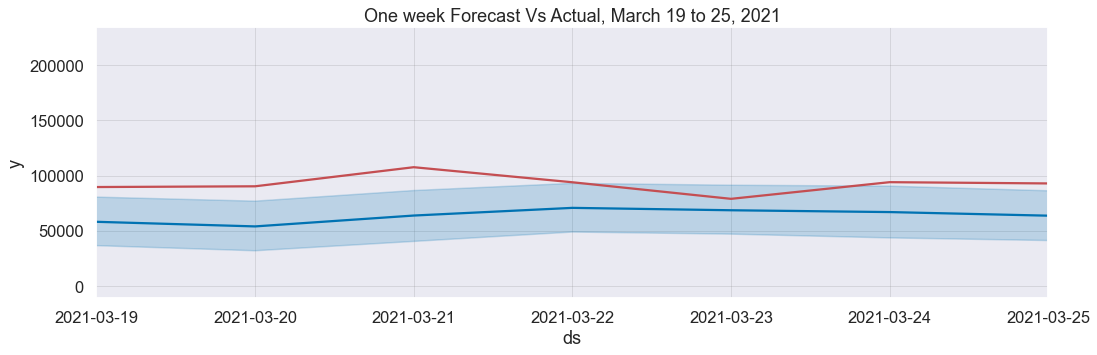

In [20]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.plot(test_df['ds'], test_df['y'], color='r')
fig = model.plot(forecast, ax=ax)
ax.set_xbound(lower='2021-03-19', upper='2021-03-25')

plt.title('One week Forecast Vs Actual, March 19 to 25, 2021')


In [21]:
# Means Squared Error and RSME
predictions=forecast.yhat[-177:]
mse=mean_squared_error(test_df.y, predictions)
rmse=sqrt(mean_squared_error(test_df.y, predictions))
print('MSE: ', mse)
print('RMSE: ', rmse)

#Mean absolute percentage error (mape)

def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Cross Validation
df_cv=cross_validation(model, horizon='30 days', initial='90', period='30 days')

mape=mean_absolute_percentage_error(df_cv.y, df_cv.yhat)
print('MAPE: ', mape)

# https://www.kaggle.com/robikscube/time-series-forecasting-with-prophet

INFO:fbprophet:Making 17 forecasts with cutoffs between 2019-06-20 00:00:00 and 2020-10-12 00:00:00


MSE:  899811135.2702816
RMSE:  29996.852089349002



MAPE:  36.91201688008837


In [22]:
df_cv.head()


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2019-06-21,19354.092767,-8670.453188,46917.686188,43981.741929,2019-06-20
1,2019-06-22,11363.594792,-17360.669260,36553.674633,19893.452452,2019-06-20
2,2019-06-23,5646.408783,-20563.228058,31868.304881,29320.384670,2019-06-20
3,2019-06-24,49314.065754,22492.436083,76008.692478,30551.167006,2019-06-20
4,2019-06-25,57026.007722,29805.608532,83250.093488,22949.698984,2019-06-20


In [23]:
df_cv.tail()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
505,2020-11-07,49517.954812,27269.278199,73162.060787,57664.612767,2020-10-12
506,2020-11-08,57983.491330,35854.644725,80132.894980,75816.136143,2020-10-12
507,2020-11-09,64247.088648,42005.220031,86714.849399,73544.655614,2020-10-12
508,2020-11-10,60981.256806,39048.514034,83782.319180,79071.010265,2020-10-12
509,2020-11-11,57563.747931,37309.467642,80531.223066,114256.453576,2020-10-12


In [24]:
### Performance Metrics
from fbprophet.diagnostics import performance_metrics
df_perf = performance_metrics(df_cv)
df_perf

,horizon,mse,rmse,mae,mape,mdape,coverage
0,3 days,2.508057e+08,15836.845273,12011.087516,0.290153,0.247875,0.823529
1,4 days,2.978871e+08,17259.406536,12575.345769,0.316178,0.220087,0.823529
2,5 days,3.672763e+08,19164.455100,13411.811690,0.350791,0.209758,0.823529
3,6 days,4.684310e+08,21643.266352,15223.559398,0.407237,0.231693,0.803922
4,7 days,6.121919e+08,24742.512943,16587.307790,0.467165,0.232381,0.784314
5,8 days,6.380665e+08,25259.978637,17062.094896,0.475495,0.250148,0.803922
6,9 days,6.427323e+08,25352.165001,16641.814405,0.444989,0.250148,0.803922
7,10 days,5.624577e+08,23716.189990,15920.791716,0.402591,0.250148,0.803922
8,11 days,6.210924e+08,24921.725604,16290.006538,0.390329,0.220537,0.803922
9,12 days,1.348789e+09,36725.857505,19471.599614,0.405964,0.220681,0.803922


In [25]:
df_perf.tail()

,horizon,mse,rmse,mae,mape,mdape,coverage
23,26 days,4.471999e+08,21147.100767,15979.205881,0.308435,0.222425,0.784314
24,27 days,4.397173e+08,20969.436766,15943.449130,0.302769,0.235209,0.784314
25,28 days,4.672283e+08,21615.465070,16083.293555,0.319498,0.235209,0.764706
26,29 days,5.254426e+08,22922.535676,17550.154585,0.367880,0.290244,0.705882
27,30 days,7.664693e+08,27685.182597,20361.736748,0.413258,0.355400,0.647059


Text(0.5, 1.0, ' Forecast Vs Actual')

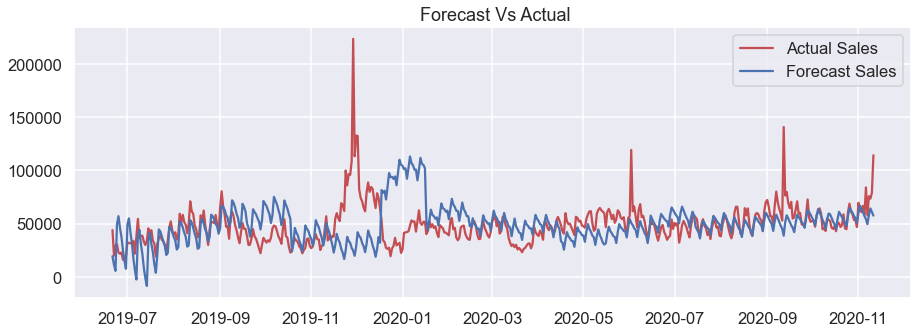

In [26]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.plot(df_cv['ds'], df_cv['y'], color='r', label='Actual Sales')
ax.plot(df_cv['ds'], df_cv['yhat'], color='b', label='Forecast Sales')
plt.legend()



plt.title(' Forecast Vs Actual')

# Hyperparameter tuning

In [27]:
from sklearn.model_selection import ParameterGrid
params_grid = {'seasonality_mode':('multiplicative','additive'),
               'changepoint_prior_scale':[0.1,0.2,0.3,0.4,0.5],
              'holidays_prior_scale':[0.1,0.2,0.3,0.4,0.5],
              'n_changepoints' : [100,150,200]}
grid = ParameterGrid(params_grid)
cnt = 0
for p in grid:
    cnt = cnt+1

print('Total Possible Models',cnt)

Total Possible Models 150


In [28]:
import itertools
param_grid = {'seasonality_mode':('multiplicative','additive'),  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
             'n_changepoints' : [3, 6, 9, 12, 15, 18, 21, 24, 25, 30]}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    cutoffs=pd.to_datetime(['2020-03-03','2020-04-28'])
    m = Prophet(**params).fit(train_df)  # Fit model with given params
    df_cv = cross_validation(m, cutoffs=cutoffs, horizon='30 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

#https://facebook.github.io/prophet/docs/diagnostics.html

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fdf3eb496d0>
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fdf40d1bb20>
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fdf3ea3c8e0>
INFO:fbprophet:Disabling yearly seaso

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fdf3eb47c70>
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fdf3eb6b190>
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fdf3eb6b7c0>
INFO:fbprophet:Disabling yearly seaso

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fdf3eace370>
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fdf3eb6b9d0>
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fdf40d1ed90>
INFO:fbprophet:Disabling yearly seaso

INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fdf40daba60>
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fdf3e946970>
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fdf3e946670>
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel w

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fdf47ca7c10>
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fdf3eb6e730>
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fdf3eb6e730>
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily season

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fdf3e94c7c0>
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fdf3e99c430>
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fdf3e9803a0>
INFO:fbprophet:Disabling yearly seaso

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fdf3e9802e0>
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fdf3eb2f700>
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fdf3eb28940>
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily season

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fdf3eb9e760>
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fdf3eae9580>
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fdf3eaa7580>
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily season

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fdf47caaf70>
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fdf3ebc39d0>
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fdf3ebf0c10>
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily season

INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fdf3ea01cd0>
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fdf3e996e20>
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fdf47cb4f10>
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel w

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fdf3e94c7c0>
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fdf3e9d2400>
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fdf3e9d2340>
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily season

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fdf3eb4bd90>
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fdf3ebc39d0>
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fdf3ebf9730>
INFO:fbprophet:Disabling yearly seaso

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fdf3eb4bee0>
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fdf3e9802e0>
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fdf3e9d2340>
INFO:fbprophet:Disabling yearly seaso

    seasonality_mode  changepoint_prior_scale  seasonality_prior_scale  \
0     multiplicative                    0.001                     0.01   
1     multiplicative                    0.001                     0.01   
2     multiplicative                    0.001                     0.01   
3     multiplicative                    0.001                     0.01   
4     multiplicative                    0.001                     0.01   
..               ...                      ...                      ...   
315         additive                    0.500                    10.00   
316         additive                    0.500                    10.00   
317         additive                    0.500                    10.00   
318         additive                    0.500                    10.00   
319         additive                    0.500                    10.00   

     n_changepoints          rmse  
0                 3  18177.982347  
1                 6  20553.511458  
2  

In [49]:

tuning_results.sort_values(by=['rmse'])

,seasonality_mode,changepoint_prior_scale,seasonality_prior_scale,n_changepoints,rmse
280,additive,0.500,0.01,3,10129.248519
130,multiplicative,0.500,0.10,3,10154.620266
140,multiplicative,0.500,1.00,3,10222.252843
150,multiplicative,0.500,10.00,3,10223.999350
290,additive,0.500,0.10,3,10289.802645
...,...,...,...,...,...
185,additive,0.001,1.00,18,20757.120105
179,additive,0.001,0.10,30,20817.613882
38,multiplicative,0.001,10.00,25,20833.529333
8,multiplicative,0.001,0.01,25,20855.210226


In [50]:
final_model=Prophet(growth='linear', daily_seasonality=True, seasonality_mode='additive', 
                    seasonality_prior_scale=0.01, changepoint_prior_scale=0.500, 
                    n_changepoints=3)
final_model.add_seasonality(name='monthly', period=30, fourier_order=1)
final_model.fit(train_df)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [51]:
future=final_model.make_future_dataframe(periods=test_df.shape[0]+30, freq='D')
final_forecast=final_model.predict(future)

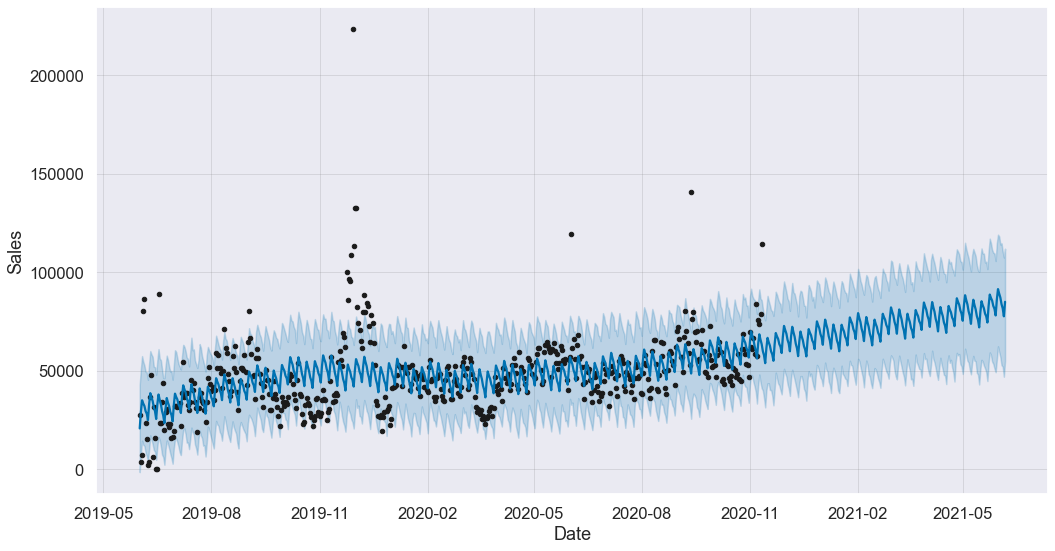

In [52]:
f, ax=plt.subplots(1)
f.set_figheight(8)
f.set_figwidth(15)

fig=final_model.plot(final_forecast, ax=ax)
ax.set_xlabel('Date')
ax.set_ylabel('Sales')
plt.show()

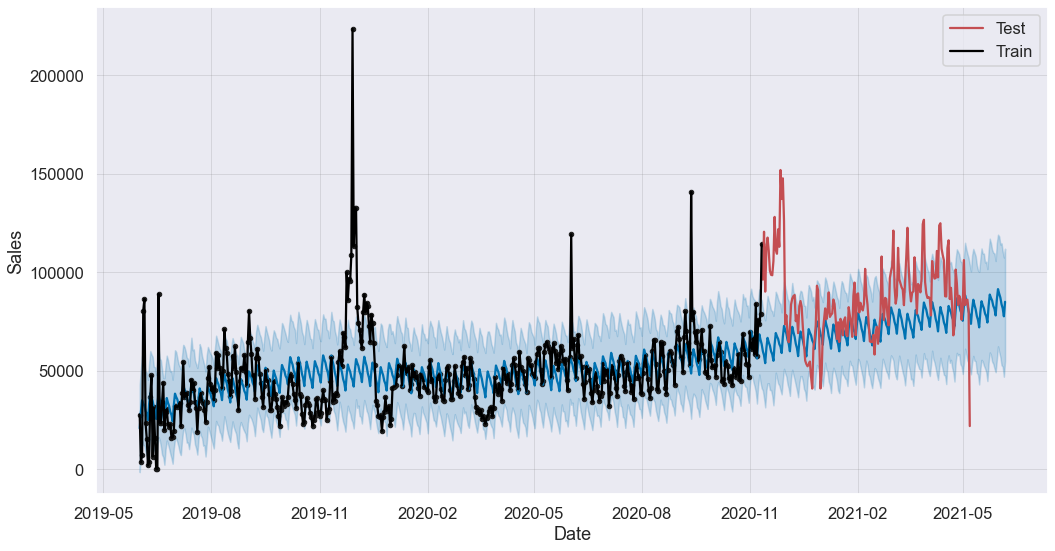

In [53]:
f, ax=plt.subplots(1)
f.set_figheight(8)
f.set_figwidth(15)


final_model.plot(final_forecast, ax=ax)
ax.plot(test_df.ds, test_df.y, color='r', label='Test')
ax.plot(train_df.ds, train_df.y, color='black', label='Train')
plt.legend()
ax.set_xlabel('Date')
ax.set_ylabel('Sales')
plt.show()

Text(0.5, 1.0, 'Forecast VS Actual Daily Sales')

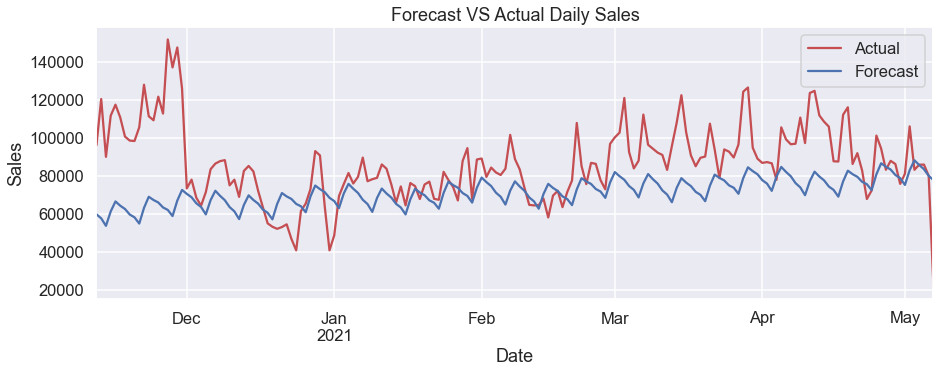

In [34]:
# Plot the forecast with the actuals
x_test_forecast=final_model.predict(test_df)

f, ax = plt.subplots(figsize=(14, 5))
f.set_figheight(5)
f.set_figwidth(15)
test_df.plot(x='ds', y='y', color='r', label='Actual', ax=ax)
x_test_forecast.plot(x='ds', y='yhat', label='Forecast', ax=ax)
plt.legend()
ax.set_xlabel('Date')
ax.set_ylabel('Sales')
plt.title('Forecast VS Actual Daily Sales')

In [35]:
mape=mean_absolute_percentage_error(test_df.y, x_test_forecast.yhat)
print('MAPE: ', mape)

MAPE:  20.29435137761849


Text(0.5, 1.0, 'One month daily sales Forecast Vs Actual after model improvement, April 07 to May 6 , 2021')

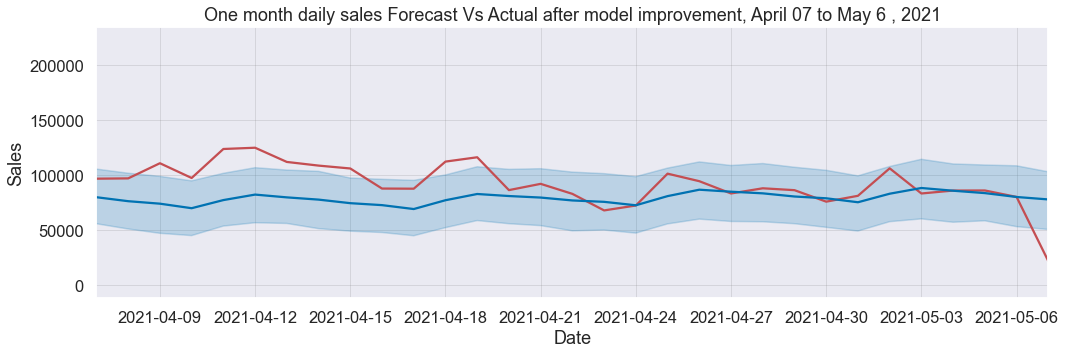

In [36]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.plot(test_df['ds'], test_df['y'], color='r')
fig = final_model.plot(final_forecast, ax=ax)
ax.set_xbound(lower='2021-04-07', upper='2021-05-07')
ax.set_xlabel('Date')
ax.set_ylabel('Sales')

plt.title('One month daily sales Forecast Vs Actual after model improvement, April 07 to May 6 , 2021')

Text(0.5, 1.0, 'One week daily sales Forecast Vs Actual after model improvement, April 07 to May 6 , 2021')

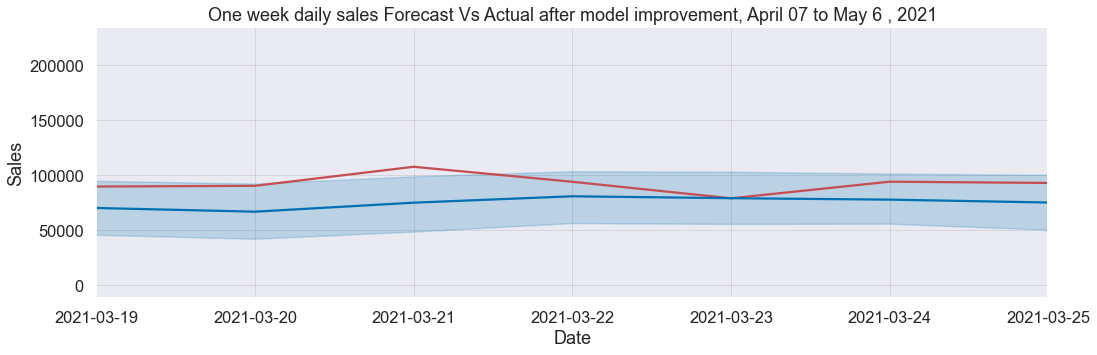

In [37]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.plot(test_df['ds'], test_df['y'], color='r')
fig = final_model.plot(final_forecast, ax=ax)
ax.set_xbound(lower='2021-03-19', upper='2021-03-25')
ax.set_xlabel('Date')
ax.set_ylabel('Sales')

plt.title('One week daily sales Forecast Vs Actual after model improvement, April 07 to May 6 , 2021')

Text(0.5, 1.0, 'One Month Daily Sales Forecast, May 01 to 30, 2021')

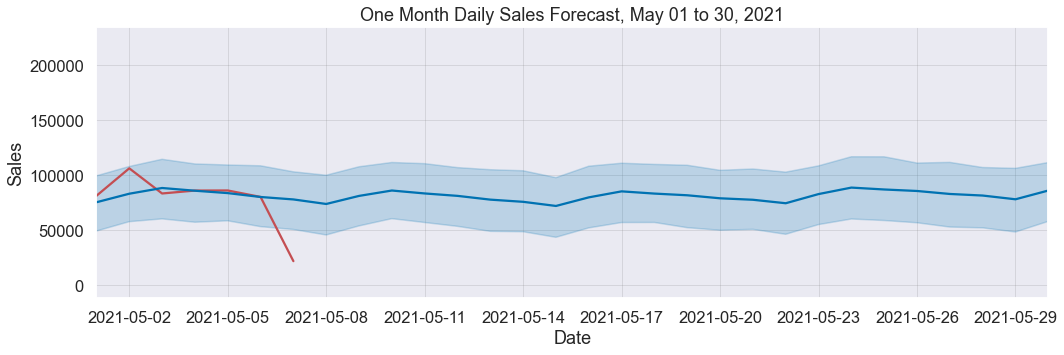

In [38]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.plot(test_df['ds'], test_df['y'], color='r')
fig = final_model.plot(final_forecast, ax=ax)
ax.set_xbound(lower='2021-05-01', upper='2021-05-30')
ax.set_xlabel('Date')
ax.set_ylabel('Sales')

plt.title('One Month Daily Sales Forecast, May 01 to 30, 2021')

In [39]:
forecast_one=forecast[['ds', 'yhat']]
forecast_two=final_forecast[['ds', 'yhat']]
forecast_one.columns=['ds', 'yhat_one']
forecast_two.columns=['ds', 'yhat_two']
forecast_combined=pd.merge(forecast_one, forecast_two, on='ds')
forecast_combined.head()

,ds,yhat_one,yhat_two
0,2019-06-01,22872.135296,20760.906483
1,2019-06-02,32896.322916,29112.005020
2,2019-06-03,39990.677221,35040.184588
3,2019-06-04,37921.366627,33392.610812
4,2019-06-05,36317.221782,32125.629879


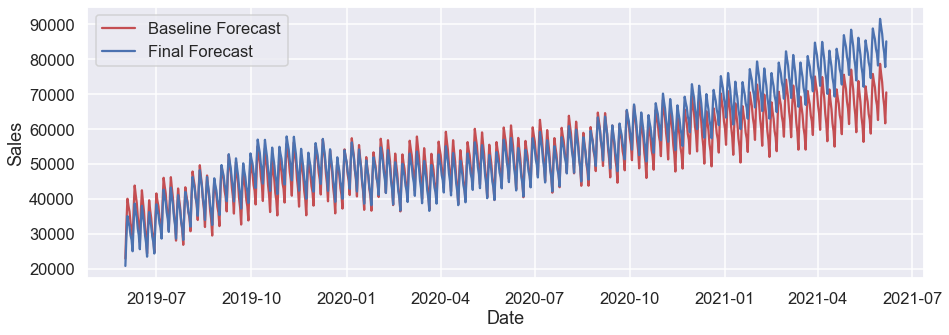

In [40]:
# Comparing the final forecast with the baseline forecast
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.plot(forecast_combined['ds'], forecast_combined['yhat_one'], color='r', label='Baseline Forecast')
ax.plot(forecast_combined['ds'], forecast_combined['yhat_two'], color='b', label='Final Forecast')

plt.legend()
ax.set_xlabel('Date')
ax.set_ylabel('Sales')
plt.show()

